In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
device = torch.device("cuda")

## Image to Tensor Conversions

In [4]:
imsize = 1024

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [5]:
set_folder = "Set11"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [6]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [7]:
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [8]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [9]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [10]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [11]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [12]:
content_layers = ['conv_5', 'conv_7']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

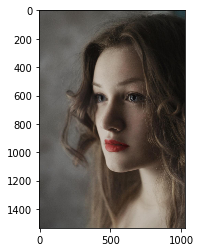

In [13]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [14]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.01)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000024 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000224 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.000707 
Iteration 2:  Style Loss = 0.000016  Content Loss = 0.001660 
Iteration 2:  Style Loss = 0.000015  Content Loss = 0.003393 
Iteration 2:  Style Loss = 0.000015  Content Loss = 0.006387 
Iteration 2:  Style Loss = 0.000014  Content Loss = 0.011003 
Iteration 2:  Style Loss = 0.000013  Content Loss = 0.016423 
Iteration 2:  Style Loss = 0.000013  Content Loss = 0.021341 
Iteration 2:  Style Loss = 0.000012  Content Loss = 0.025385 
Iteration 2:  Style Loss = 0.000012  Content Loss = 0.029063 
Iteration 2:  Style Loss = 0.000012  Content Loss = 0.032615 
Iteratio

Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107590 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107647 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107700 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107751 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107799 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107843 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107885 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107924 
Iteration 8:  Style Loss = 0.000002  Content Loss = 0.107960 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.107993 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.108024 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.108051 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.108076 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.108099 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.108118 
Iteration 9:  Style Loss = 0.000002  Content Loss = 0.108135 
Iteratio

Iteration 15:  Style Loss = 0.000001  Content Loss = 0.098860 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.098728 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.098596 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.098465 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.098335 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.098205 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.098075 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097947 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097820 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097693 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097567 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097441 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097316 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097193 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.097070 
Iteration 15:  Style Loss = 0.000001  Content Loss = 0.

Iteration 21:  Style Loss = 0.000000  Content Loss = 0.088225 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.088182 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.088139 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.088097 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.088056 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.088015 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.087975 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087934 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087894 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087854 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087814 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087774 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087735 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087696 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.087657 
Iteration 22:  Style Loss = 0.000000  Content Loss = 0.

Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084783 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084786 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084791 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084795 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084799 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084804 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084810 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084816 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084822 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084829 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084837 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084844 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084853 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084863 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.084873 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 34:  Style Loss = 0.000000  Content Loss = 0.088205 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.088229 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.088258 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.088286 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.088308 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088334 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088363 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088386 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088409 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088437 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088462 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088484 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088508 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088534 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.088556 
Iteration 35:  Style Loss = 0.000000  Content Loss = 0.

Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090422 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090433 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090445 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090457 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090468 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090480 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090492 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090503 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090514 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090526 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090537 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090549 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090561 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.090572 
Iteration 42:  Style Loss = 0.000000  Content Loss = 0.090583 
Iteration 42:  Style Loss = 0.000000  Content Loss = 0.

Iteration 47:  Style Loss = 0.000000  Content Loss = 0.091799 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.091807 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.091816 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091824 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091833 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091841 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091850 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091858 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091867 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091875 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091883 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091891 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091899 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091907 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.091915 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.

Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092414 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092407 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092398 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092388 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092377 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092366 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092355 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092343 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092332 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092320 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092308 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.092296 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.092284 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.092272 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.092260 
Iteration 55:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.090205 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.090178 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.090151 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.090123 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.090096 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.090069 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.090041 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.090013 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.089986 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.089958 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.089930 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.089902 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.089875 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.089847 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.089819 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.

Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086793 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086773 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086753 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086733 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086713 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086694 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086675 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086656 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086637 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.086619 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.086600 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.086582 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.086564 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.086546 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.086528 
Iteration 68:  Style Loss = 0.000000  Content Loss = 0.

Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085102 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085093 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085084 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085074 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085065 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085056 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085047 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085038 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085029 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085020 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085011 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.085002 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.084994 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.084985 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.084976 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.

Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084164 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084158 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084153 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084148 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084143 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084137 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084132 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.084127 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.084122 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.084117 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.084111 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.084106 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.084101 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.084096 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.084091 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.

Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083588 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083585 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083581 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083577 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083574 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083570 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083567 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083563 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083560 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083556 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083552 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083549 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083545 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083542 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.083538 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 93:  Style Loss = 0.000000  Content Loss = 0.083151 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.083147 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.083144 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.083140 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.083137 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.083133 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083130 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083127 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083123 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083120 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083116 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083113 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083109 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083105 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.083102 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.

Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082482 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082473 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082464 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082454 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082445 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082435 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082425 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082415 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082405 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082395 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082385 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082375 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082364 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082353 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.082342 
Iteration 100:  Style Loss = 0.000000  C

Iteration 106:  Style Loss = 0.000000  Content Loss = 0.080911 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.080900 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.080890 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.080879 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.080868 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.080857 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.080847 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080836 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080826 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080815 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080805 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080795 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080785 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080775 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.080765 
Iteration 107:  Style Loss = 0.000000  C

Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079696 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079686 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079676 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079666 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079656 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079646 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079636 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079625 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079615 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079605 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079594 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079584 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079573 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079563 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.079552 
Iteration 113:  Style Loss = 0.000000  C

Iteration 119:  Style Loss = 0.000000  Content Loss = 0.078040 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.078028 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.078016 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.078005 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.077993 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.077982 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.077970 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.077959 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.077948 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.077937 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.077926 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.077915 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.077904 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.077894 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.077883 
Iteration 120:  Style Loss = 0.000000  C

Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077141 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077136 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077132 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077128 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077124 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077120 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077116 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077112 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077108 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077104 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077100 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077096 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077092 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077088 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.077084 
Iteration 126:  Style Loss = 0.000000  C

Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076472 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076463 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076454 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076446 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076437 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076428 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076420 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076411 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076402 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076393 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.076384 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.076375 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.076366 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.076357 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.076348 
Iteration 133:  Style Loss = 0.000000  C

Iteration 138:  Style Loss = 0.000000  Content Loss = 0.075689 
Iteration 138:  Style Loss = 0.000000  Content Loss = 0.075686 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075683 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075681 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075679 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075676 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075674 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075671 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075669 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075667 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075664 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075662 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075660 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075658 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.075655 
Iteration 139:  Style Loss = 0.000000  C

Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075422 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075419 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075416 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075413 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075411 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075408 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075405 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075402 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075399 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075395 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075392 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075389 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.075386 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.075383 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.075379 
Iteration 146:  Style Loss = 0.000000  C

Iteration 151:  Style Loss = 0.000000  Content Loss = 0.074361 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.074349 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.074337 
Iteration 151:  Style Loss = 0.000000  Content Loss = 0.074325 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074313 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074301 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074290 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074278 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074267 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074255 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074244 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074232 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074220 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074209 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.074198 
Iteration 152:  Style Loss = 0.000000  C

Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073352 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073347 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073342 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073338 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073333 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073328 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073323 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073318 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073314 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073309 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073304 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073300 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073295 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073290 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.073286 
Iteration 159:  Style Loss = 0.000000  C

Iteration 164:  Style Loss = 0.000000  Content Loss = 0.072779 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.072773 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.072768 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.072762 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.072757 
Iteration 164:  Style Loss = 0.000000  Content Loss = 0.072751 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072746 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072740 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072734 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072728 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072723 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072717 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072711 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072705 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.072699 
Iteration 165:  Style Loss = 0.000000  C

Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071645 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071638 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071632 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071625 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071618 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071612 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071606 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071600 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071594 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071588 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071582 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071576 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071570 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071565 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.071559 
Iteration 171:  Style Loss = 0.000000  C

Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071254 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071253 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071251 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071250 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071249 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071247 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071246 
Iteration 177:  Style Loss = 0.000000  Content Loss = 0.071244 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.071243 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.071242 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.071240 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.071239 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.071237 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.071236 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.071235 
Iteration 178:  Style Loss = 0.000000  C

Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070955 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070950 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070944 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070938 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070932 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070927 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070921 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070915 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070908 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070902 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070896 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070889 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070883 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070876 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.070869 
Iteration 184:  Style Loss = 0.000000  C

Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070238 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070235 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070233 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070230 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070227 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070224 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070222 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070219 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070216 
Iteration 190:  Style Loss = 0.000000  Content Loss = 0.070214 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.070211 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.070209 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.070206 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.070204 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.070201 
Iteration 191:  Style Loss = 0.000000  C

Iteration 196:  Style Loss = 0.000000  Content Loss = 0.069992 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069990 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069988 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069987 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069985 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069983 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069981 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069979 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069978 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069976 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069974 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069972 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069970 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069968 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.069967 
Iteration 197:  Style Loss = 0.000000  C

Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069519 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069512 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069506 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069500 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069494 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069488 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069482 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069477 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069471 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069465 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069459 
Iteration 203:  Style Loss = 0.000000  Content Loss = 0.069454 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.069448 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.069443 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.069437 
Iteration 204:  Style Loss = 0.000000  C

Iteration 209:  Style Loss = 0.000000  Content Loss = 0.069129 
Iteration 209:  Style Loss = 0.000000  Content Loss = 0.069129 
Iteration 209:  Style Loss = 0.000000  Content Loss = 0.069128 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069127 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069127 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069126 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069125 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069124 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069124 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069123 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069122 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069122 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069121 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069121 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.069120 
Iteration 210:  Style Loss = 0.000000  C

Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069065 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069065 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069064 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069063 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069062 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069061 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069061 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069060 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069059 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069058 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069057 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069056 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069055 
Iteration 216:  Style Loss = 0.000000  Content Loss = 0.069054 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.069053 
Iteration 217:  Style Loss = 0.000000  C

Iteration 222:  Style Loss = 0.000000  Content Loss = 0.068642 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.068638 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.068634 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.068630 
Iteration 222:  Style Loss = 0.000000  Content Loss = 0.068626 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068622 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068619 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068615 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068611 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068608 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068604 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068601 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068597 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068594 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.068590 
Iteration 223:  Style Loss = 0.000000  C

Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068391 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068390 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068389 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068388 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068387 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068386 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068385 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068384 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068383 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068382 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068381 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068380 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068379 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068378 
Iteration 229:  Style Loss = 0.000000  Content Loss = 0.068377 
Iteration 229:  Style Loss = 0.000000  C

Iteration 235:  Style Loss = 0.000000  Content Loss = 0.068214 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.068212 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.068209 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.068207 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.068204 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.068201 
Iteration 235:  Style Loss = 0.000000  Content Loss = 0.068198 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068196 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068193 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068190 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068187 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068184 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068181 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068178 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.068174 
Iteration 236:  Style Loss = 0.000000  C

Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067744 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067742 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067740 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067738 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067736 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067734 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067733 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067731 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067729 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067727 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067726 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067724 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067723 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067721 
Iteration 242:  Style Loss = 0.000000  Content Loss = 0.067720 
Iteration 242:  Style Loss = 0.000000  C

Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067665 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067665 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067665 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067665 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067665 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067664 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067664 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067664 
Iteration 248:  Style Loss = 0.000000  Content Loss = 0.067664 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.067664 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.067663 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.067663 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.067663 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.067663 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.067662 
Iteration 249:  Style Loss = 0.000000  C

Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067512 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067508 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067505 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067501 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067497 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067493 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067489 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067486 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067482 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067478 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067473 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067469 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067465 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067461 
Iteration 255:  Style Loss = 0.000000  Content Loss = 0.067457 
Iteration 255:  Style Loss = 0.000000  C

Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067125 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067124 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067123 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067122 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067122 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067121 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067120 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067119 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067118 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067117 
Iteration 261:  Style Loss = 0.000000  Content Loss = 0.067116 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.067115 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.067114 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.067114 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.067113 
Iteration 262:  Style Loss = 0.000000  C

Iteration 267:  Style Loss = 0.000000  Content Loss = 0.067050 
Iteration 267:  Style Loss = 0.000000  Content Loss = 0.067049 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067048 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067047 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067047 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067046 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067045 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067044 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067043 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067043 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067042 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067041 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067040 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067039 
Iteration 268:  Style Loss = 0.000000  Content Loss = 0.067038 
Iteration 268:  Style Loss = 0.000000  C

Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066768 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066764 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066760 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066756 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066752 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066748 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066744 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066740 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066736 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066733 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066729 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066725 
Iteration 274:  Style Loss = 0.000000  Content Loss = 0.066721 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.066718 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.066714 
Iteration 275:  Style Loss = 0.000000  C

Iteration 280:  Style Loss = 0.000000  Content Loss = 0.066514 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.066513 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.066513 
Iteration 280:  Style Loss = 0.000000  Content Loss = 0.066513 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066513 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066512 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066512 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066512 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066512 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066512 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066511 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066511 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066511 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066511 
Iteration 281:  Style Loss = 0.000000  Content Loss = 0.066511 
Iteration 281:  Style Loss = 0.000000  C

Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066479 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066478 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066477 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066476 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066475 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066474 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066473 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066472 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066470 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066469 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066468 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066467 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066466 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066464 
Iteration 287:  Style Loss = 0.000000  Content Loss = 0.066463 
Iteration 288:  Style Loss = 0.000000  C

Iteration 293:  Style Loss = 0.000000  Content Loss = 0.066106 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.066103 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.066100 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.066097 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.066094 
Iteration 293:  Style Loss = 0.000000  Content Loss = 0.066091 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066088 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066085 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066082 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066079 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066076 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066074 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066071 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066068 
Iteration 294:  Style Loss = 0.000000  Content Loss = 0.066065 
Iteration 294:  Style Loss = 0.000000  C

Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065940 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065940 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065939 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065939 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065939 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065939 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065939 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065939 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065938 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065938 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065938 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065938 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065938 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065938 
Iteration 300:  Style Loss = 0.000000  Content Loss = 0.065938 
Iteration 300:  Style Loss = 0.000000  C

Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065888 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065886 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065885 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065884 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065883 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065882 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065880 
Iteration 306:  Style Loss = 0.000000  Content Loss = 0.065879 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.065878 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.065876 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.065875 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.065874 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.065872 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.065871 
Iteration 307:  Style Loss = 0.000000  Content Loss = 0.065869 
Iteration 307:  Style Loss = 0.000000  C

Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065598 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065597 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065595 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065593 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065591 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065590 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065588 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065587 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065585 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065584 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065582 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065581 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065580 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065578 
Iteration 313:  Style Loss = 0.000000  Content Loss = 0.065577 
Iteration 313:  Style Loss = 0.000000  C

Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 319:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 320:  Style Loss = 0.000000  Content Loss = 0.065535 
Iteration 320:  Style Loss = 0.000000  C

Iteration 325:  Style Loss = 0.000000  Content Loss = 0.065434 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065432 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065429 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065427 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065425 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065422 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065420 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065417 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065415 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065413 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065410 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065407 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065405 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065402 
Iteration 326:  Style Loss = 0.000000  Content Loss = 0.065400 
Iteration 326:  Style Loss = 0.000000  C

Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065106 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065105 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065104 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065102 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065101 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065100 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065099 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065097 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065096 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065095 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065094 
Iteration 332:  Style Loss = 0.000000  Content Loss = 0.065093 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.065092 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.065091 
Iteration 333:  Style Loss = 0.000000  Content Loss = 0.065089 
Iteration 333:  Style Loss = 0.000000  C

Iteration 338:  Style Loss = 0.000000  Content Loss = 0.065047 
Iteration 338:  Style Loss = 0.000000  Content Loss = 0.065046 
Iteration 338:  Style Loss = 0.000000  Content Loss = 0.065046 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065046 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065046 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065046 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065046 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065045 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065045 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065045 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065045 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065045 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065044 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065044 
Iteration 339:  Style Loss = 0.000000  Content Loss = 0.065044 
Iteration 339:  Style Loss = 0.000000  C

Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064939 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064937 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064935 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064933 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064932 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064930 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064928 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064926 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064924 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064922 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064920 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064919 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064917 
Iteration 345:  Style Loss = 0.000000  Content Loss = 0.064915 
Iteration 346:  Style Loss = 0.000000  Content Loss = 0.064913 
Iteration 346:  Style Loss = 0.000000  C

Iteration 351:  Style Loss = 0.000000  Content Loss = 0.064777 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.064777 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.064777 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.064776 
Iteration 351:  Style Loss = 0.000000  Content Loss = 0.064776 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064776 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064776 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064776 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064775 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064775 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064775 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064775 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064775 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064775 
Iteration 352:  Style Loss = 0.000000  Content Loss = 0.064775 
Iteration 352:  Style Loss = 0.000000  C

Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064771 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064771 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064771 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064770 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064770 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064769 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064769 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064768 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064768 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064767 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064767 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064766 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064766 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064765 
Iteration 358:  Style Loss = 0.000000  Content Loss = 0.064765 
Iteration 358:  Style Loss = 0.000000  C

Iteration 364:  Style Loss = 0.000000  Content Loss = 0.064582 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.064579 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.064577 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.064575 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.064573 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.064570 
Iteration 364:  Style Loss = 0.000000  Content Loss = 0.064568 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064566 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064564 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064561 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064559 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064557 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064555 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064553 
Iteration 365:  Style Loss = 0.000000  Content Loss = 0.064551 
Iteration 365:  Style Loss = 0.000000  C

Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064402 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064401 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064401 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064400 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064400 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064399 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064398 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064398 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064398 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064397 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064397 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064396 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064396 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064395 
Iteration 371:  Style Loss = 0.000000  Content Loss = 0.064395 
Iteration 371:  Style Loss = 0.000000  C

Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064346 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064345 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064345 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064344 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064343 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064342 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064342 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064341 
Iteration 377:  Style Loss = 0.000000  Content Loss = 0.064340 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.064339 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.064338 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.064337 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.064336 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.064336 
Iteration 378:  Style Loss = 0.000000  Content Loss = 0.064335 
Iteration 378:  Style Loss = 0.000000  C

Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064197 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064196 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064195 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064194 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064193 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064192 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064192 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064191 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064190 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064189 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064188 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064187 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064187 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064186 
Iteration 384:  Style Loss = 0.000000  Content Loss = 0.064185 
Iteration 384:  Style Loss = 0.000000  C

Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064171 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064172 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064172 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064172 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064172 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064172 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064172 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064172 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064173 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064173 
Iteration 390:  Style Loss = 0.000000  Content Loss = 0.064173 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.064173 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.064173 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.064173 
Iteration 391:  Style Loss = 0.000000  Content Loss = 0.064173 
Iteration 391:  Style Loss = 0.000000  C

Iteration 396:  Style Loss = 0.000000  Content Loss = 0.064136 
Iteration 396:  Style Loss = 0.000000  Content Loss = 0.064135 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064134 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064133 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064132 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064131 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064130 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064128 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064127 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064126 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064125 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064124 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064123 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064122 
Iteration 397:  Style Loss = 0.000000  Content Loss = 0.064120 
Iteration 397:  Style Loss = 0.000000  C

Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063956 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063955 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063954 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063952 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063951 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063950 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063949 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063948 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063947 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063946 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063945 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063943 
Iteration 403:  Style Loss = 0.000000  Content Loss = 0.063942 
Iteration 404:  Style Loss = 0.000000  Content Loss = 0.063941 
Iteration 404:  Style Loss = 0.000000  Content Loss = 0.063940 
Iteration 404:  Style Loss = 0.000000  C

Iteration 409:  Style Loss = 0.000000  Content Loss = 0.063864 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.063864 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.063863 
Iteration 409:  Style Loss = 0.000000  Content Loss = 0.063863 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063862 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063862 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063861 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063860 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063860 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063859 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063859 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063858 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063858 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063857 
Iteration 410:  Style Loss = 0.000000  Content Loss = 0.063857 
Iteration 410:  Style Loss = 0.000000  C

Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063761 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063760 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063759 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063758 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063757 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063756 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063755 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063754 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063753 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063752 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063751 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063750 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063749 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063748 
Iteration 416:  Style Loss = 0.000000  Content Loss = 0.063747 
Iteration 417:  Style Loss = 0.000000  C

Iteration 422:  Style Loss = 0.000000  Content Loss = 0.063695 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.063695 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.063695 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.063695 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 422:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063696 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063697 
Iteration 423:  Style Loss = 0.000000  Content Loss = 0.063697 
Iteration 423:  Style Loss = 0.000000  C

Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063718 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063718 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063718 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063718 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063718 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063718 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  Content Loss = 0.063717 
Iteration 429:  Style Loss = 0.000000  C

Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063637 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063635 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063634 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063633 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063632 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063631 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063630 
Iteration 435:  Style Loss = 0.000000  Content Loss = 0.063628 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.063627 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.063626 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.063625 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.063624 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.063623 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.063621 
Iteration 436:  Style Loss = 0.000000  Content Loss = 0.063620 
Iteration 436:  Style Loss = 0.000000  C

Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063509 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063509 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063508 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063507 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063507 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063506 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063505 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063505 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063504 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063504 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063503 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063502 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063502 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063501 
Iteration 442:  Style Loss = 0.000000  Content Loss = 0.063500 
Iteration 442:  Style Loss = 0.000000  C

Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063423 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063422 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063421 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063420 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063420 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063419 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063418 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063417 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063416 
Iteration 448:  Style Loss = 0.000000  Content Loss = 0.063415 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.063415 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.063414 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.063413 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.063412 
Iteration 449:  Style Loss = 0.000000  Content Loss = 0.063411 
Iteration 449:  Style Loss = 0.000000  C

Iteration 454:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063327 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063327 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063326 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063326 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063326 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063325 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063325 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063324 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063324 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063324 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063323 
Iteration 455:  Style Loss = 0.000000  Content Loss = 0.063323 
Iteration 455:  Style Loss = 0.000000  C

Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063327 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063327 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063327 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063329 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063329 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063329 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063329 
Iteration 461:  Style Loss = 0.000000  Content Loss = 0.063330 
Iteration 462:  Style Loss = 0.000000  Content Loss = 0.063330 
Iteration 462:  Style Loss = 0.000000  Content Loss = 0.063330 
Iteration 462:  Style Loss = 0.000000  Content Loss = 0.063330 
Iteration 462:  Style Loss = 0.000000  C

Iteration 467:  Style Loss = 0.000000  Content Loss = 0.063328 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.063327 
Iteration 467:  Style Loss = 0.000000  Content Loss = 0.063327 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063326 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063326 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063326 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063325 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063325 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063324 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063324 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063323 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063323 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063322 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063322 
Iteration 468:  Style Loss = 0.000000  Content Loss = 0.063321 
Iteration 468:  Style Loss = 0.000000  C

Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063232 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063232 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063231 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063230 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063229 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063228 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063227 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063226 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063225 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063225 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063224 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063223 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063222 
Iteration 474:  Style Loss = 0.000000  Content Loss = 0.063221 
Iteration 475:  Style Loss = 0.000000  Content Loss = 0.063220 
Iteration 475:  Style Loss = 0.000000  C

Iteration 480:  Style Loss = 0.000000  Content Loss = 0.063137 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.063137 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.063136 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.063135 
Iteration 480:  Style Loss = 0.000000  Content Loss = 0.063135 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063134 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063133 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063133 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063132 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063131 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063131 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063130 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063129 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063129 
Iteration 481:  Style Loss = 0.000000  Content Loss = 0.063128 
Iteration 481:  Style Loss = 0.000000  C

Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063043 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063042 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063041 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063041 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063040 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063039 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063039 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063038 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063037 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063037 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063036 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063035 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063035 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063034 
Iteration 487:  Style Loss = 0.000000  Content Loss = 0.063033 
Iteration 487:  Style Loss = 0.000000  C

Iteration 493:  Style Loss = 0.000000  Content Loss = 0.062987 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 493:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 494:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 494:  Style Loss = 0.000000  C

Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062986 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  Content Loss = 0.062985 
Iteration 500:  Style Loss = 0.000000  C

Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062957 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062957 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062957 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062956 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062956 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062955 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062955 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062954 
Iteration 506:  Style Loss = 0.000000  Content Loss = 0.062954 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.062954 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.062953 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.062953 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.062952 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.062952 
Iteration 507:  Style Loss = 0.000000  Content Loss = 0.062951 
Iteration 507:  Style Loss = 0.000000  C

Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062885 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062884 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062883 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062883 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062882 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062881 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062881 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062880 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062879 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062879 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062878 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062877 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062877 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062876 
Iteration 513:  Style Loss = 0.000000  Content Loss = 0.062875 
Iteration 513:  Style Loss = 0.000000  C

Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062796 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062795 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062795 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062794 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062793 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062792 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062792 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062791 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062790 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062789 
Iteration 519:  Style Loss = 0.000000  Content Loss = 0.062789 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.062788 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.062787 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.062786 
Iteration 520:  Style Loss = 0.000000  Content Loss = 0.062786 
Iteration 520:  Style Loss = 0.000000  C

Iteration 525:  Style Loss = 0.000000  Content Loss = 0.062716 
Iteration 525:  Style Loss = 0.000000  Content Loss = 0.062716 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062715 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062715 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062715 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062714 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062714 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062713 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062713 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062713 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062712 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062712 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062711 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062711 
Iteration 526:  Style Loss = 0.000000  Content Loss = 0.062711 
Iteration 526:  Style Loss = 0.000000  C

Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062682 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062682 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062682 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062682 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062682 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062681 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062681 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062681 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062681 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062681 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062681 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062681 
Iteration 532:  Style Loss = 0.000000  Content Loss = 0.062680 
Iteration 533:  Style Loss = 0.000000  Content Loss = 0.062680 
Iteration 533:  Style Loss = 0.000000  Content Loss = 0.062680 
Iteration 533:  Style Loss = 0.000000  C

Iteration 538:  Style Loss = 0.000000  Content Loss = 0.062665 
Iteration 538:  Style Loss = 0.000000  Content Loss = 0.062665 
Iteration 538:  Style Loss = 0.000000  Content Loss = 0.062665 
Iteration 538:  Style Loss = 0.000000  Content Loss = 0.062665 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062665 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062664 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062664 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062664 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062664 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062664 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062664 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062663 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062663 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062663 
Iteration 539:  Style Loss = 0.000000  Content Loss = 0.062663 
Iteration 539:  Style Loss = 0.000000  C

Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062635 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062634 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062634 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062634 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062633 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062633 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062633 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062632 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062632 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062631 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062631 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062630 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062630 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062630 
Iteration 545:  Style Loss = 0.000000  Content Loss = 0.062629 
Iteration 546:  Style Loss = 0.000000  C

Iteration 551:  Style Loss = 0.000000  Content Loss = 0.062567 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.062567 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.062566 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.062565 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.062565 
Iteration 551:  Style Loss = 0.000000  Content Loss = 0.062564 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062563 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062563 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062562 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062561 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062561 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062560 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062559 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062559 
Iteration 552:  Style Loss = 0.000000  Content Loss = 0.062558 
Iteration 552:  Style Loss = 0.000000  C

Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062480 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062479 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062479 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062478 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062478 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062477 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062476 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062476 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062475 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062475 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062474 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062473 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062473 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062472 
Iteration 558:  Style Loss = 0.000000  Content Loss = 0.062471 
Iteration 558:  Style Loss = 0.000000  C

Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062413 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062412 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062412 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062411 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062411 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062411 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062410 
Iteration 564:  Style Loss = 0.000000  Content Loss = 0.062410 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.062409 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.062409 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.062408 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.062408 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.062408 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.062407 
Iteration 565:  Style Loss = 0.000000  Content Loss = 0.062407 
Iteration 565:  Style Loss = 0.000000  C

Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062362 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062362 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062361 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062361 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062361 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062360 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062360 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062359 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062359 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062359 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062358 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062358 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062358 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062357 
Iteration 571:  Style Loss = 0.000000  Content Loss = 0.062357 
Iteration 571:  Style Loss = 0.000000  C

Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062317 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062316 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062316 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062315 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062315 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062315 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062314 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062314 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062314 
Iteration 577:  Style Loss = 0.000000  Content Loss = 0.062313 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.062313 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.062313 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.062312 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.062312 
Iteration 578:  Style Loss = 0.000000  Content Loss = 0.062312 
Iteration 578:  Style Loss = 0.000000  C

Iteration 583:  Style Loss = 0.000000  Content Loss = 0.062253 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062253 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062252 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062252 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062251 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062250 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062250 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062249 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062248 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062248 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062247 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062247 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062246 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062245 
Iteration 584:  Style Loss = 0.000000  Content Loss = 0.062245 
Iteration 584:  Style Loss = 0.000000  C

Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062176 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062175 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062174 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062174 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062173 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062173 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062172 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062172 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062171 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062170 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062170 
Iteration 590:  Style Loss = 0.000000  Content Loss = 0.062169 
Iteration 591:  Style Loss = 0.000000  Content Loss = 0.062168 
Iteration 591:  Style Loss = 0.000000  Content Loss = 0.062168 
Iteration 591:  Style Loss = 0.000000  Content Loss = 0.062167 
Iteration 591:  Style Loss = 0.000000  C

Iteration 596:  Style Loss = 0.000000  Content Loss = 0.062098 
Iteration 596:  Style Loss = 0.000000  Content Loss = 0.062097 
Iteration 596:  Style Loss = 0.000000  Content Loss = 0.062096 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062096 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062095 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062094 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062094 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062093 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062092 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062092 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062091 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062090 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062090 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062089 
Iteration 597:  Style Loss = 0.000000  Content Loss = 0.062088 
Iteration 597:  Style Loss = 0.000000  C

Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062007 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062007 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062006 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062005 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062005 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062004 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062003 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062003 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062002 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062001 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062001 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.062000 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.061999 
Iteration 603:  Style Loss = 0.000000  Content Loss = 0.061999 
Iteration 604:  Style Loss = 0.000000  Content Loss = 0.061998 
Iteration 604:  Style Loss = 0.000000  C

Iteration 609:  Style Loss = 0.000000  Content Loss = 0.061932 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.061932 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.061931 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.061931 
Iteration 609:  Style Loss = 0.000000  Content Loss = 0.061930 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061930 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061929 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061929 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061928 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061928 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061927 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061926 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061926 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061925 
Iteration 610:  Style Loss = 0.000000  Content Loss = 0.061925 
Iteration 610:  Style Loss = 0.000000  C

Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061853 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061852 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061851 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061850 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061849 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061849 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061848 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061847 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061846 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061845 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061845 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061844 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061843 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061842 
Iteration 616:  Style Loss = 0.000000  Content Loss = 0.061841 
Iteration 616:  Style Loss = 0.000000  C

Iteration 622:  Style Loss = 0.000000  Content Loss = 0.061754 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.061754 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.061753 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.061753 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.061752 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.061752 
Iteration 622:  Style Loss = 0.000000  Content Loss = 0.061751 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061751 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061750 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061750 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061749 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061749 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061748 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061748 
Iteration 623:  Style Loss = 0.000000  Content Loss = 0.061747 
Iteration 623:  Style Loss = 0.000000  C

Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061700 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061699 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061699 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061698 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061698 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061697 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061697 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061696 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061696 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061696 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061695 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061695 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061694 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061694 
Iteration 629:  Style Loss = 0.000000  Content Loss = 0.061693 
Iteration 629:  Style Loss = 0.000000  C

Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061615 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061614 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061613 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061612 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061611 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061610 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061609 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061609 
Iteration 635:  Style Loss = 0.000000  Content Loss = 0.061608 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.061607 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.061606 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.061605 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.061605 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.061604 
Iteration 636:  Style Loss = 0.000000  Content Loss = 0.061603 
Iteration 636:  Style Loss = 0.000000  C

Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061523 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061522 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061522 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061521 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061521 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061520 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061520 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061519 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061519 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061518 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061518 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061518 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061517 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061517 
Iteration 642:  Style Loss = 0.000000  Content Loss = 0.061516 
Iteration 642:  Style Loss = 0.000000  C

Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061471 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061470 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061470 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061469 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061469 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061468 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061468 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061467 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061467 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061466 
Iteration 648:  Style Loss = 0.000000  Content Loss = 0.061466 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.061465 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.061465 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.061464 
Iteration 649:  Style Loss = 0.000000  Content Loss = 0.061464 
Iteration 649:  Style Loss = 0.000000  C

Iteration 654:  Style Loss = 0.000000  Content Loss = 0.061385 
Iteration 654:  Style Loss = 0.000000  Content Loss = 0.061384 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061384 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061383 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061382 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061381 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061381 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061380 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061379 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061379 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061378 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061378 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061377 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061376 
Iteration 655:  Style Loss = 0.000000  Content Loss = 0.061376 
Iteration 655:  Style Loss = 0.000000  C

Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061338 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061337 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061337 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061337 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061337 
Iteration 661:  Style Loss = 0.000000  Content Loss = 0.061337 
Iteration 662:  Style Loss = 0.000000  Content Loss = 0.061337 
Iteration 662:  Style Loss = 0.000000  Content Loss = 0.061337 
Iteration 662:  Style Loss = 0.000000  C

Iteration 667:  Style Loss = 0.000000  Content Loss = 0.061310 
Iteration 667:  Style Loss = 0.000000  Content Loss = 0.061310 
Iteration 667:  Style Loss = 0.000000  Content Loss = 0.061309 
Iteration 667:  Style Loss = 0.000000  Content Loss = 0.061309 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061308 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061308 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061307 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061307 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061306 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061306 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061305 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061305 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061304 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061304 
Iteration 668:  Style Loss = 0.000000  Content Loss = 0.061303 
Iteration 668:  Style Loss = 0.000000  C

Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061226 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061225 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061225 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061224 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061223 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061223 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061222 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061222 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061221 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061221 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061220 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061219 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061219 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061218 
Iteration 674:  Style Loss = 0.000000  Content Loss = 0.061218 
Iteration 675:  Style Loss = 0.000000  C

Iteration 680:  Style Loss = 0.000000  Content Loss = 0.061175 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.061175 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.061175 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.061175 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.061174 
Iteration 680:  Style Loss = 0.000000  Content Loss = 0.061174 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061174 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061173 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061173 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061173 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061173 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061172 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061172 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061172 
Iteration 681:  Style Loss = 0.000000  Content Loss = 0.061171 
Iteration 681:  Style Loss = 0.000000  C

Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061120 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061120 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061119 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061118 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061118 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061117 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061116 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061116 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061115 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061115 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061114 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061113 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061113 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061112 
Iteration 687:  Style Loss = 0.000000  Content Loss = 0.061111 
Iteration 687:  Style Loss = 0.000000  C

Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061053 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061053 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061052 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061052 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061052 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061052 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061051 
Iteration 693:  Style Loss = 0.000000  Content Loss = 0.061051 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.061051 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.061051 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.061051 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.061050 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.061050 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.061050 
Iteration 694:  Style Loss = 0.000000  Content Loss = 0.061050 
Iteration 694:  Style Loss = 0.000000  C

Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061042 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061042 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061042 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061042 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061042 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061042 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061041 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061041 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061041 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061041 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061041 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061041 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061040 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061040 
Iteration 700:  Style Loss = 0.000000  Content Loss = 0.061040 
Iteration 700:  Style Loss = 0.000000  C

Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060984 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060983 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060982 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060982 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060981 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060980 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060980 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060979 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060978 
Iteration 706:  Style Loss = 0.000000  Content Loss = 0.060977 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.060977 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.060976 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.060975 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.060975 
Iteration 707:  Style Loss = 0.000000  Content Loss = 0.060974 
Iteration 707:  Style Loss = 0.000000  C

Iteration 712:  Style Loss = 0.000000  Content Loss = 0.060910 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060909 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060909 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060908 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060908 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060908 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060907 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060907 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060906 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060906 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060906 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060905 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060905 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060905 
Iteration 713:  Style Loss = 0.000000  Content Loss = 0.060904 
Iteration 713:  Style Loss = 0.000000  C

Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060858 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060858 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060857 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060856 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060856 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060855 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060855 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060854 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060853 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060853 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060852 
Iteration 719:  Style Loss = 0.000000  Content Loss = 0.060852 
Iteration 720:  Style Loss = 0.000000  Content Loss = 0.060851 
Iteration 720:  Style Loss = 0.000000  Content Loss = 0.060850 
Iteration 720:  Style Loss = 0.000000  Content Loss = 0.060850 
Iteration 720:  Style Loss = 0.000000  C

Iteration 725:  Style Loss = 0.000000  Content Loss = 0.060776 
Iteration 725:  Style Loss = 0.000000  Content Loss = 0.060775 
Iteration 725:  Style Loss = 0.000000  Content Loss = 0.060775 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060774 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060774 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060773 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060773 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060772 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060772 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060772 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060771 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060771 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060770 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060770 
Iteration 726:  Style Loss = 0.000000  Content Loss = 0.060769 
Iteration 726:  Style Loss = 0.000000  C

Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060753 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060752 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060752 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060752 
Iteration 732:  Style Loss = 0.000000  Content Loss = 0.060752 
Iteration 733:  Style Loss = 0.000000  Content Loss = 0.060752 
Iteration 733:  Style Loss = 0.000000  C

Iteration 738:  Style Loss = 0.000000  Content Loss = 0.060717 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.060716 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.060716 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.060715 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.060714 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060714 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060713 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060712 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060711 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060711 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060710 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060709 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060709 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060708 
Iteration 739:  Style Loss = 0.000000  Content Loss = 0.060707 
Iteration 739:  Style Loss = 0.000000  C

Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060625 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060624 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060624 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060623 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060623 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060622 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060621 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060621 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060620 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060620 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060619 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060619 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060618 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060617 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.060617 
Iteration 745:  Style Loss = 0.000000  C

Iteration 751:  Style Loss = 0.000000  Content Loss = 0.060556 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.060556 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.060555 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.060555 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.060554 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.060553 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.060553 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060552 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060551 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060551 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060550 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060550 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060549 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060548 
Iteration 752:  Style Loss = 0.000000  Content Loss = 0.060548 
Iteration 752:  Style Loss = 0.000000  C

Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060443 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060442 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060441 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060440 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060439 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060438 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060437 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060436 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060436 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060435 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060434 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060433 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060432 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060431 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.060430 
Iteration 758:  Style Loss = 0.000000  C

Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.060385 
Iteration 765:  Style Loss = 0.000000  Content Loss = 0.060384 
Iteration 765:  Style Loss = 0.000000  C

Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060366 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060365 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060365 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060364 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060364 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060363 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060362 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060362 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060361 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060361 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060360 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060359 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060359 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060358 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.060357 
Iteration 771:  Style Loss = 0.000000  C

Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060237 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060236 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060235 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060234 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060234 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060233 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060232 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060231 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060230 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060229 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.060228 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.060227 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.060226 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.060225 
Iteration 778:  Style Loss = 0.000000  Content Loss = 0.060225 
Iteration 778:  Style Loss = 0.000000  C

Iteration 783:  Style Loss = 0.000000  Content Loss = 0.060153 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.060152 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060152 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060151 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060150 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060150 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060149 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060148 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060148 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060147 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060146 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060146 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060145 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060145 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.060144 
Iteration 784:  Style Loss = 0.000000  C

Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060027 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060026 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060024 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060023 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060022 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060020 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060019 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060017 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060016 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060015 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060013 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060012 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.060010 
Iteration 791:  Style Loss = 0.000000  Content Loss = 0.060009 
Iteration 791:  Style Loss = 0.000000  Content Loss = 0.060007 
Iteration 791:  Style Loss = 0.000000  C

Iteration 796:  Style Loss = 0.000000  Content Loss = 0.059874 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.059873 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.059872 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.059872 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059871 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059871 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059870 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059870 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059869 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059869 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059868 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059868 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059867 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059867 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.059867 
Iteration 797:  Style Loss = 0.000000  C

Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059846 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059846 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059845 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059845 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059845 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059845 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059845 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059844 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059844 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059844 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059844 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059843 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059843 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059843 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.059843 
Iteration 804:  Style Loss = 0.000000  C

Iteration 809:  Style Loss = 0.000000  Content Loss = 0.059751 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.059749 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.059748 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.059747 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.059745 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.059744 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059743 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059741 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059740 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059738 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059737 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059736 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059734 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059733 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.059731 
Iteration 810:  Style Loss = 0.000000  C

Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059610 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059609 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059609 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059608 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059607 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059607 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059606 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059606 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059605 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059605 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059604 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059603 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059603 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059602 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.059602 
Iteration 816:  Style Loss = 0.000000  C

Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059539 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059539 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059538 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059537 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059537 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059536 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059535 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.059534 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.059534 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.059533 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.059532 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.059532 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.059531 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.059530 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.059529 
Iteration 823:  Style Loss = 0.000000  C

Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059424 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059423 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059422 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059421 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059421 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059420 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059419 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059418 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059417 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059416 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059415 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059414 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059413 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059413 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.059412 
Iteration 829:  Style Loss = 0.000000  C

Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059367 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059367 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059367 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059367 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059367 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 835:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 836:  Style Loss = 0.000000  Content Loss = 0.059366 
Iteration 836:  Style Loss = 0.000000  C

Iteration 841:  Style Loss = 0.000000  Content Loss = 0.059351 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059351 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059350 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059350 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059350 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059349 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059349 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059348 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059348 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059348 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059347 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059347 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059346 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059346 
Iteration 842:  Style Loss = 0.000000  Content Loss = 0.059345 
Iteration 842:  Style Loss = 0.000000  C

Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059261 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059261 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059260 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059259 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059258 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059258 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059257 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059256 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059256 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059255 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059254 
Iteration 848:  Style Loss = 0.000000  Content Loss = 0.059254 
Iteration 849:  Style Loss = 0.000000  Content Loss = 0.059253 
Iteration 849:  Style Loss = 0.000000  Content Loss = 0.059252 
Iteration 849:  Style Loss = 0.000000  Content Loss = 0.059252 
Iteration 849:  Style Loss = 0.000000  C

Iteration 854:  Style Loss = 0.000000  Content Loss = 0.059206 
Iteration 854:  Style Loss = 0.000000  Content Loss = 0.059206 
Iteration 854:  Style Loss = 0.000000  Content Loss = 0.059205 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059205 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059205 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059204 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059204 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059204 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059204 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059203 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059203 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059203 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059202 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059202 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.059202 
Iteration 855:  Style Loss = 0.000000  C

Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059152 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059152 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059151 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059151 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059150 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059149 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059149 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059148 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059148 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059147 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059147 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059146 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059145 
Iteration 861:  Style Loss = 0.000000  Content Loss = 0.059145 
Iteration 862:  Style Loss = 0.000000  Content Loss = 0.059144 
Iteration 862:  Style Loss = 0.000000  C

Iteration 867:  Style Loss = 0.000000  Content Loss = 0.059095 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.059094 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.059094 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.059094 
Iteration 867:  Style Loss = 0.000000  Content Loss = 0.059094 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059094 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059094 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059093 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059093 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059093 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059093 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059093 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059093 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059092 
Iteration 868:  Style Loss = 0.000000  Content Loss = 0.059092 
Iteration 868:  Style Loss = 0.000000  C

Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059087 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059086 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059086 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059086 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059086 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059086 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059086 
Iteration 874:  Style Loss = 0.000000  Content Loss = 0.059086 
Iteration 874:  Style Loss = 0.000000  C

Iteration 880:  Style Loss = 0.000000  Content Loss = 0.059041 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.059041 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.059040 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.059039 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.059039 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.059038 
Iteration 880:  Style Loss = 0.000000  Content Loss = 0.059038 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059037 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059036 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059036 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059035 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059034 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059034 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059033 
Iteration 881:  Style Loss = 0.000000  Content Loss = 0.059033 
Iteration 881:  Style Loss = 0.000000  C

Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058981 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058981 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058981 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058981 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058980 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058980 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058980 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058980 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058980 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058979 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058979 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058979 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058979 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058978 
Iteration 887:  Style Loss = 0.000000  Content Loss = 0.058978 
Iteration 887:  Style Loss = 0.000000  C

Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058956 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058956 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058956 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058955 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058955 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058955 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058955 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058954 
Iteration 893:  Style Loss = 0.000000  Content Loss = 0.058954 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.058954 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.058953 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.058953 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.058953 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.058952 
Iteration 894:  Style Loss = 0.000000  Content Loss = 0.058952 
Iteration 894:  Style Loss = 0.000000  C

Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058905 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058904 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058904 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058903 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058903 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058903 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058902 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058902 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058902 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058901 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058901 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058901 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058900 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058900 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.058900 
Iteration 900:  Style Loss = 0.000000  C

Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 906:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.058886 
Iteration 907:  Style Loss = 0.000000  C

Iteration 912:  Style Loss = 0.000000  Content Loss = 0.058870 
Iteration 912:  Style Loss = 0.000000  Content Loss = 0.058870 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058870 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058869 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058869 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058868 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058868 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058868 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058867 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058867 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058866 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058866 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058866 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058865 
Iteration 913:  Style Loss = 0.000000  Content Loss = 0.058865 
Iteration 913:  Style Loss = 0.000000  C

Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058806 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058806 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058805 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058805 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058805 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058804 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058804 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058803 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058803 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058803 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058802 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058802 
Iteration 919:  Style Loss = 0.000000  Content Loss = 0.058801 
Iteration 920:  Style Loss = 0.000000  Content Loss = 0.058801 
Iteration 920:  Style Loss = 0.000000  Content Loss = 0.058801 
Iteration 920:  Style Loss = 0.000000  C

Iteration 925:  Style Loss = 0.000000  Content Loss = 0.058777 
Iteration 925:  Style Loss = 0.000000  Content Loss = 0.058777 
Iteration 925:  Style Loss = 0.000000  Content Loss = 0.058777 
Iteration 925:  Style Loss = 0.000000  Content Loss = 0.058777 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058777 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058777 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058776 
Iteration 926:  Style Loss = 0.000000  Content Loss = 0.058775 
Iteration 926:  Style Loss = 0.000000  C

Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058740 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058740 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058739 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058739 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058739 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058738 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058738 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058737 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058737 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058736 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058736 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058735 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058735 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058734 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.058734 
Iteration 933:  Style Loss = 0.000000  C

Iteration 938:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 938:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 939:  Style Loss = 0.000000  C

Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058700 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058699 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058698 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058698 
Iteration 945:  Style Loss = 0.000000  Content Loss = 0.058698 
Iteration 945:  Style Loss = 0.000000  C

Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058654 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058654 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058653 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058653 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058652 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058652 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058651 
Iteration 951:  Style Loss = 0.000000  Content Loss = 0.058651 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.058650 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.058650 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.058649 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.058648 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.058648 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.058647 
Iteration 952:  Style Loss = 0.000000  Content Loss = 0.058647 
Iteration 952:  Style Loss = 0.000000  C

Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058603 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058603 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058603 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058602 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058602 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058602 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058602 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058602 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058602 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058601 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058601 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058601 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058601 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058601 
Iteration 958:  Style Loss = 0.000000  Content Loss = 0.058600 
Iteration 958:  Style Loss = 0.000000  C

Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058578 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058577 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058577 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058577 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058576 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058576 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058576 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058575 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058575 
Iteration 964:  Style Loss = 0.000000  Content Loss = 0.058574 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.058574 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.058574 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.058573 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.058573 
Iteration 965:  Style Loss = 0.000000  Content Loss = 0.058572 
Iteration 965:  Style Loss = 0.000000  C

Iteration 970:  Style Loss = 0.000000  Content Loss = 0.058519 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058518 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058518 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058518 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058518 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058517 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058517 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058517 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058517 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058516 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058516 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058516 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058516 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058515 
Iteration 971:  Style Loss = 0.000000  Content Loss = 0.058515 
Iteration 971:  Style Loss = 0.000000  C

Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058522 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058523 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058523 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058523 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058523 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058523 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058524 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058524 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058524 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058524 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058524 
Iteration 977:  Style Loss = 0.000000  Content Loss = 0.058525 
Iteration 978:  Style Loss = 0.000000  Content Loss = 0.058525 
Iteration 978:  Style Loss = 0.000000  Content Loss = 0.058525 
Iteration 978:  Style Loss = 0.000000  Content Loss = 0.058525 
Iteration 978:  Style Loss = 0.000000  C

Iteration 983:  Style Loss = 0.000000  Content Loss = 0.058519 
Iteration 983:  Style Loss = 0.000000  Content Loss = 0.058519 
Iteration 983:  Style Loss = 0.000000  Content Loss = 0.058519 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058518 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058518 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058517 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058517 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058516 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058516 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058516 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058515 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058515 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058514 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058514 
Iteration 984:  Style Loss = 0.000000  Content Loss = 0.058513 
Iteration 984:  Style Loss = 0.000000  C

Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 990:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 991:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 991:  Style Loss = 0.000000  C

Iteration 996:  Style Loss = 0.000000  Content Loss = 0.058470 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 996:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058469 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058468 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 997:  Style Loss = 0.000000  Content Loss = 0.058467 
Iteration 997:  Style Loss = 0.000000  C

Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058402 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058401 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058401 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058400 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058399 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058399 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058398 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058398 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058397 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058396 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058396 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058395 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058395 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058394 
Iteration 1003:  Style Loss = 0.000000  Content Loss = 0.058394 
Iteration 1003:  Style Lo

Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058417 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058418 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058418 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058419 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058420 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058421 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058422 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058423 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058423 
Iteration 1009:  Style Loss = 0.000000  Content Loss = 0.058424 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.058425 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.058426 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.058427 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.058428 
Iteration 1010:  Style Loss = 0.000000  Content Loss = 0.058429 
Iteration 1010:  Style Lo

Iteration 1015:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1015:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1015:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058497 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058498 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058498 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058498 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058498 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058498 
Iteration 1016:  Style Loss = 0.000000  Content Loss = 0.058498 
Iteration 1016:  Style Lo

Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058451 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058451 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058450 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058449 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058448 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058447 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058447 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058446 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058445 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058444 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058444 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058443 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058442 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058441 
Iteration 1022:  Style Loss = 0.000000  Content Loss = 0.058440 
Iteration 1022:  Style Lo

Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058323 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058322 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058320 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058319 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058317 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058316 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058314 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058312 
Iteration 1028:  Style Loss = 0.000000  Content Loss = 0.058311 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.058309 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.058307 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.058306 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.058304 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.058302 
Iteration 1029:  Style Loss = 0.000000  Content Loss = 0.058301 
Iteration 1029:  Style Lo

Iteration 1034:  Style Loss = 0.000000  Content Loss = 0.057990 
Iteration 1034:  Style Loss = 0.000000  Content Loss = 0.057987 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057983 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057979 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057975 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057972 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057968 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057964 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057960 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057957 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057953 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057949 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057945 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057941 
Iteration 1035:  Style Loss = 0.000000  Content Loss = 0.057938 
Iteration 1035:  Style Lo

Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057475 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057471 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057467 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057462 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057458 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057454 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057450 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057445 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057441 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057437 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057433 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057428 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057424 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057420 
Iteration 1041:  Style Loss = 0.000000  Content Loss = 0.057415 
Iteration 1042:  Style Lo

Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056958 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056954 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056949 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056946 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056941 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056937 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056933 
Iteration 1047:  Style Loss = 0.000000  Content Loss = 0.056929 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.056925 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.056920 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.056916 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.056912 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.056908 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.056904 
Iteration 1048:  Style Loss = 0.000000  Content Loss = 0.056900 
Iteration 1048:  Style Lo

Iteration 1053:  Style Loss = 0.000000  Content Loss = 0.056436 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056432 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056428 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056424 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056420 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056416 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056412 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056408 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056404 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056400 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056396 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056391 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056387 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056383 
Iteration 1054:  Style Loss = 0.000000  Content Loss = 0.056380 
Iteration 1054:  Style Lo

Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055970 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055967 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055964 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055960 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055957 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055954 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055951 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055948 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055944 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055941 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055938 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055935 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055932 
Iteration 1060:  Style Loss = 0.000000  Content Loss = 0.055929 
Iteration 1061:  Style Loss = 0.000000  Content Loss = 0.055925 
Iteration 1061:  Style Lo

Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.055572 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.055569 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.055566 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.055563 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.055560 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.055557 
Iteration 1066:  Style Loss = 0.000000  Content Loss = 0.055554 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055551 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055548 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055545 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055542 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055539 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055537 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055534 
Iteration 1067:  Style Loss = 0.000000  Content Loss = 0.055531 
Iteration 1067:  Style Lo

Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055240 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055238 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055236 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055234 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055232 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055230 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055227 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055225 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055223 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055221 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055219 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055217 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055215 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055213 
Iteration 1073:  Style Loss = 0.000000  Content Loss = 0.055211 
Iteration 1073:  Style Lo

Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.055006 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.055004 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.055003 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.055001 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054999 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054998 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054996 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054995 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054993 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054991 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054990 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054988 
Iteration 1079:  Style Loss = 0.000000  Content Loss = 0.054986 
Iteration 1080:  Style Loss = 0.000000  Content Loss = 0.054985 
Iteration 1080:  Style Loss = 0.000000  Content Loss = 0.054983 
Iteration 1080:  Style Lo

Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.054821 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.054820 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.054818 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.054817 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.054816 
Iteration 1085:  Style Loss = 0.000000  Content Loss = 0.054815 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054813 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054812 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054811 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054810 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054808 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054807 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054806 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054805 
Iteration 1086:  Style Loss = 0.000000  Content Loss = 0.054803 
Iteration 1086:  Style Lo

Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054684 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054683 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054683 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054682 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054681 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054680 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054679 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054678 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054677 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054676 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054675 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054674 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054674 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054673 
Iteration 1092:  Style Loss = 0.000000  Content Loss = 0.054672 
Iteration 1092:  Style Lo

Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054581 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054580 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054579 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054579 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054578 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054577 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054576 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054576 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054575 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054574 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054573 
Iteration 1098:  Style Loss = 0.000000  Content Loss = 0.054572 
Iteration 1099:  Style Loss = 0.000000  Content Loss = 0.054572 
Iteration 1099:  Style Loss = 0.000000  Content Loss = 0.054571 
Iteration 1099:  Style Loss = 0.000000  Content Loss = 0.054570 
Iteration 1099:  Style Lo

Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.054494 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.054493 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.054493 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.054492 
Iteration 1104:  Style Loss = 0.000000  Content Loss = 0.054492 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054491 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054490 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054490 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054489 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054489 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054488 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054487 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054487 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054486 
Iteration 1105:  Style Loss = 0.000000  Content Loss = 0.054486 
Iteration 1105:  Style Lo

Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054428 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054428 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054428 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054427 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054427 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054426 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054426 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054425 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054425 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054424 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054424 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054424 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054423 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054423 
Iteration 1111:  Style Loss = 0.000000  Content Loss = 0.054422 
Iteration 1111:  Style Lo

Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054374 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054374 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054373 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054373 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054372 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054372 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054371 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054371 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054371 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054370 
Iteration 1117:  Style Loss = 0.000000  Content Loss = 0.054370 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.054369 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.054369 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.054368 
Iteration 1118:  Style Loss = 0.000000  Content Loss = 0.054368 
Iteration 1118:  Style Lo

Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.054320 
Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.054320 
Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.054320 
Iteration 1123:  Style Loss = 0.000000  Content Loss = 0.054319 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054319 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054318 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054318 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054318 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054317 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054317 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054317 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054316 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054316 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054316 
Iteration 1124:  Style Loss = 0.000000  Content Loss = 0.054315 
Iteration 1124:  Style Lo

Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054284 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054283 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054283 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054283 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054283 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054282 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054282 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054282 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054282 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054281 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054281 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054281 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054281 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054280 
Iteration 1130:  Style Loss = 0.000000  Content Loss = 0.054280 
Iteration 1130:  Style Lo

Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054250 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054249 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054249 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054249 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054249 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054248 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054248 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054248 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054247 
Iteration 1136:  Style Loss = 0.000000  Content Loss = 0.054247 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.054247 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.054246 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.054246 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.054246 
Iteration 1137:  Style Loss = 0.000000  Content Loss = 0.054246 
Iteration 1137:  Style Lo

Iteration 1142:  Style Loss = 0.000000  Content Loss = 0.054216 
Iteration 1142:  Style Loss = 0.000000  Content Loss = 0.054216 
Iteration 1142:  Style Loss = 0.000000  Content Loss = 0.054216 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054216 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054215 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054215 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054215 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054215 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054215 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054214 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054214 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054214 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054214 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054214 
Iteration 1143:  Style Loss = 0.000000  Content Loss = 0.054213 
Iteration 1143:  Style Lo

Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054192 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054192 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054192 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054192 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054191 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054191 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054191 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054191 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054191 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054190 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054190 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054190 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054190 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054190 
Iteration 1149:  Style Loss = 0.000000  Content Loss = 0.054189 
Iteration 1149:  Style Lo

Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054163 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054163 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054163 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054163 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054162 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054162 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054162 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054162 
Iteration 1155:  Style Loss = 0.000000  Content Loss = 0.054161 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.054161 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.054161 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.054161 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.054160 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.054160 
Iteration 1156:  Style Loss = 0.000000  Content Loss = 0.054160 
Iteration 1156:  Style Lo

Iteration 1161:  Style Loss = 0.000000  Content Loss = 0.054134 
Iteration 1161:  Style Loss = 0.000000  Content Loss = 0.054133 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054133 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054133 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054133 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054133 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054132 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054132 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054132 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054132 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054132 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054131 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054131 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054131 
Iteration 1162:  Style Loss = 0.000000  Content Loss = 0.054131 
Iteration 1162:  Style Lo

Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054112 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054112 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054112 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054112 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054111 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054111 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054111 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054111 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054111 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054111 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054110 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054110 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054110 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054110 
Iteration 1168:  Style Loss = 0.000000  Content Loss = 0.054110 
Iteration 1169:  Style Lo

Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054091 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054090 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054090 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054090 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054090 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054090 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054090 
Iteration 1174:  Style Loss = 0.000000  Content Loss = 0.054089 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.054089 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.054089 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.054089 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.054089 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.054088 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.054088 
Iteration 1175:  Style Loss = 0.000000  Content Loss = 0.054088 
Iteration 1175:  Style Lo

Iteration 1180:  Style Loss = 0.000000  Content Loss = 0.054071 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054071 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054071 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054070 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054070 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054070 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054070 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054070 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054070 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054070 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054069 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054069 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054069 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054069 
Iteration 1181:  Style Loss = 0.000000  Content Loss = 0.054069 
Iteration 1181:  Style Lo

Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054050 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054050 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054050 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054049 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054049 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054049 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054049 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054049 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054048 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054048 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054048 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054048 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054048 
Iteration 1187:  Style Loss = 0.000000  Content Loss = 0.054047 
Iteration 1188:  Style Loss = 0.000000  Content Loss = 0.054047 
Iteration 1188:  Style Lo

Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.054023 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.054023 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.054023 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.054022 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.054022 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.054022 
Iteration 1193:  Style Loss = 0.000000  Content Loss = 0.054022 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054022 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054021 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054021 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054021 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054021 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054021 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054020 
Iteration 1194:  Style Loss = 0.000000  Content Loss = 0.054020 
Iteration 1194:  Style Lo

Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054001 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054001 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054000 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054000 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054000 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054000 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054000 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.054000 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.053999 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.053999 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.053999 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.053999 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.053999 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.053999 
Iteration 1200:  Style Loss = 0.000000  Content Loss = 0.053998 
Iteration 1200:  Style Lo

Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053979 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053979 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053978 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053978 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053978 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053978 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053978 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053977 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053977 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053977 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053977 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053977 
Iteration 1206:  Style Loss = 0.000000  Content Loss = 0.053976 
Iteration 1207:  Style Loss = 0.000000  Content Loss = 0.053976 
Iteration 1207:  Style Loss = 0.000000  Content Loss = 0.053976 
Iteration 1207:  Style Lo

Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.053955 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.053955 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.053955 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.053954 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.053954 
Iteration 1212:  Style Loss = 0.000000  Content Loss = 0.053954 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053954 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053954 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053954 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053954 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053953 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053953 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053953 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053953 
Iteration 1213:  Style Loss = 0.000000  Content Loss = 0.053953 
Iteration 1213:  Style Lo

Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053938 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053937 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053937 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053937 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053937 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053937 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053937 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053937 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053936 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053936 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053936 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053936 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053936 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053936 
Iteration 1219:  Style Loss = 0.000000  Content Loss = 0.053936 
Iteration 1219:  Style Lo

Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053914 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053914 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053913 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053913 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053913 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053913 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053912 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053912 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053912 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053912 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053911 
Iteration 1225:  Style Loss = 0.000000  Content Loss = 0.053911 
Iteration 1226:  Style Loss = 0.000000  Content Loss = 0.053911 
Iteration 1226:  Style Loss = 0.000000  Content Loss = 0.053911 
Iteration 1226:  Style Loss = 0.000000  Content Loss = 0.053910 
Iteration 1226:  Style Lo

Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.053883 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.053883 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.053882 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.053882 
Iteration 1231:  Style Loss = 0.000000  Content Loss = 0.053882 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053882 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053881 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053881 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053881 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053881 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053880 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053880 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053880 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053880 
Iteration 1232:  Style Loss = 0.000000  Content Loss = 0.053880 
Iteration 1232:  Style Lo

Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053847 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053847 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053846 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053846 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053846 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053845 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053845 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053845 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053844 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053844 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053844 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053843 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053843 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053842 
Iteration 1238:  Style Loss = 0.000000  Content Loss = 0.053842 
Iteration 1238:  Style Lo

Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053804 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053804 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053804 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053803 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053803 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053803 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053803 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053803 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053802 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053802 
Iteration 1244:  Style Loss = 0.000000  Content Loss = 0.053802 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.053802 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.053801 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.053801 
Iteration 1245:  Style Loss = 0.000000  Content Loss = 0.053801 
Iteration 1245:  Style Lo

Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1250:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Loss = 0.000000  Content Loss = 0.053792 
Iteration 1251:  Style Lo

Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053776 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053776 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053775 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053775 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053775 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053774 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053774 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053774 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053773 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053773 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053773 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053772 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053772 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053772 
Iteration 1257:  Style Loss = 0.000000  Content Loss = 0.053771 
Iteration 1257:  Style Lo

Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053719 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053719 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053718 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053717 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053717 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053716 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053716 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053715 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053715 
Iteration 1263:  Style Loss = 0.000000  Content Loss = 0.053714 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.053713 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.053713 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.053712 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.053712 
Iteration 1264:  Style Loss = 0.000000  Content Loss = 0.053711 
Iteration 1264:  Style Lo

Iteration 1269:  Style Loss = 0.000000  Content Loss = 0.053621 
Iteration 1269:  Style Loss = 0.000000  Content Loss = 0.053620 
Iteration 1269:  Style Loss = 0.000000  Content Loss = 0.053619 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053618 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053617 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053616 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053615 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053614 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053613 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053612 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053610 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053609 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053608 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053607 
Iteration 1270:  Style Loss = 0.000000  Content Loss = 0.053606 
Iteration 1270:  Style Lo

Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053464 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053463 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053461 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053460 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053459 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053458 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053457 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053455 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053454 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053453 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053451 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053450 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053449 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053448 
Iteration 1276:  Style Loss = 0.000000  Content Loss = 0.053447 
Iteration 1276:  Style Lo

Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053334 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053333 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053333 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053332 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053331 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053330 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053329 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053328 
Iteration 1282:  Style Loss = 0.000000  Content Loss = 0.053327 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.053327 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.053326 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.053325 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.053324 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.053323 
Iteration 1283:  Style Loss = 0.000000  Content Loss = 0.053322 
Iteration 1283:  Style Lo

Iteration 1288:  Style Loss = 0.000000  Content Loss = 0.053210 
Iteration 1288:  Style Loss = 0.000000  Content Loss = 0.053209 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053208 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053207 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053206 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053204 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053203 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053202 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053201 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053199 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053198 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053197 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053196 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053195 
Iteration 1289:  Style Loss = 0.000000  Content Loss = 0.053193 
Iteration 1289:  Style Lo

Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053057 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053056 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053055 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053054 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053053 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053052 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053051 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053050 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053049 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053048 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053047 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053046 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053045 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053044 
Iteration 1295:  Style Loss = 0.000000  Content Loss = 0.053043 
Iteration 1296:  Style Lo

Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052956 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052955 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052955 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052954 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052953 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052953 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052952 
Iteration 1301:  Style Loss = 0.000000  Content Loss = 0.052951 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.052951 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.052950 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.052950 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.052949 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.052948 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.052948 
Iteration 1302:  Style Loss = 0.000000  Content Loss = 0.052947 
Iteration 1302:  Style Lo

Iteration 1307:  Style Loss = 0.000000  Content Loss = 0.052876 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052876 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052875 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052875 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052874 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052873 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052873 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052872 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052871 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052871 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052870 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052869 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052869 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052868 
Iteration 1308:  Style Loss = 0.000000  Content Loss = 0.052867 
Iteration 1308:  Style Lo

Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052801 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052800 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052800 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052799 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052799 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052799 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052798 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052798 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052797 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052797 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052796 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052796 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052796 
Iteration 1314:  Style Loss = 0.000000  Content Loss = 0.052795 
Iteration 1315:  Style Loss = 0.000000  Content Loss = 0.052795 
Iteration 1315:  Style Lo

Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.052760 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.052760 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.052760 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.052759 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.052759 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.052759 
Iteration 1320:  Style Loss = 0.000000  Content Loss = 0.052759 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052758 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052758 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052758 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052758 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052758 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052757 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052757 
Iteration 1321:  Style Loss = 0.000000  Content Loss = 0.052757 
Iteration 1321:  Style Lo

Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052732 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052732 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052732 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052732 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052731 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052731 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052731 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052731 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052731 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052730 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052730 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052730 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052730 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052729 
Iteration 1327:  Style Loss = 0.000000  Content Loss = 0.052729 
Iteration 1327:  Style Lo

Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052706 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052706 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052706 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052706 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052706 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052706 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052705 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052705 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052705 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052705 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052705 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052705 
Iteration 1333:  Style Loss = 0.000000  Content Loss = 0.052705 
Iteration 1334:  Style Loss = 0.000000  Content Loss = 0.052704 
Iteration 1334:  Style Loss = 0.000000  Content Loss = 0.052704 
Iteration 1334:  Style Lo

Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.052688 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.052688 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.052688 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.052688 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.052688 
Iteration 1339:  Style Loss = 0.000000  Content Loss = 0.052688 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052687 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052687 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052687 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052687 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052687 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052687 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052687 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052686 
Iteration 1340:  Style Loss = 0.000000  Content Loss = 0.052686 
Iteration 1340:  Style Lo

Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052669 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052669 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052669 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052669 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052669 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052669 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052669 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052668 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052668 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052668 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052668 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052668 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052668 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052667 
Iteration 1346:  Style Loss = 0.000000  Content Loss = 0.052667 
Iteration 1346:  Style Lo

Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052651 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052650 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052649 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052649 
Iteration 1352:  Style Loss = 0.000000  Content Loss = 0.052649 
Iteration 1353:  Style Loss = 0.000000  Content Loss = 0.052649 
Iteration 1353:  Style Loss = 0.000000  Content Loss = 0.052649 
Iteration 1353:  Style Loss = 0.000000  Content Loss = 0.052649 
Iteration 1353:  Style Lo

Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.052634 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.052634 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.052634 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.052634 
Iteration 1358:  Style Loss = 0.000000  Content Loss = 0.052634 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052634 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052634 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Loss = 0.000000  Content Loss = 0.052633 
Iteration 1359:  Style Lo

Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052620 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052620 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052620 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052619 
Iteration 1365:  Style Loss = 0.000000  Content Loss = 0.052618 
Iteration 1365:  Style Lo

Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1371:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1372:  Style Loss = 0.000000  Content Loss = 0.052610 
Iteration 1372:  Style Lo

Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1377:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052601 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052600 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052600 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052600 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052600 
Iteration 1378:  Style Loss = 0.000000  Content Loss = 0.052600 
Iteration 1378:  Style Lo

Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052586 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052586 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052586 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052586 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052586 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052585 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052585 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052585 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052585 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052585 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052585 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052585 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052584 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052584 
Iteration 1384:  Style Loss = 0.000000  Content Loss = 0.052584 
Iteration 1384:  Style Lo

Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052569 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052569 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052569 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052569 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052569 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052569 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052569 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1390:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1391:  Style Loss = 0.000000  Content Loss = 0.052568 
Iteration 1391:  Style Lo

Iteration 1396:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1396:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1396:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052557 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052556 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052556 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052556 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052556 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052556 
Iteration 1397:  Style Loss = 0.000000  Content Loss = 0.052556 
Iteration 1397:  Style Lo

Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052547 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052546 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052546 
Iteration 1403:  Style Loss = 0.000000  Content Loss = 0.052546 
Iteration 1403:  Style Lo

Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052538 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052538 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1409:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.052537 
Iteration 1410:  Style Loss = 0.000000  Content Loss = 0.052536 
Iteration 1410:  Style Lo

Iteration 1415:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1415:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052526 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052525 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052525 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052525 
Iteration 1416:  Style Loss = 0.000000  Content Loss = 0.052525 
Iteration 1416:  Style Lo

Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052529 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052530 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052530 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052530 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052530 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052530 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052531 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052531 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052531 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052531 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052532 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052532 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052532 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052532 
Iteration 1422:  Style Loss = 0.000000  Content Loss = 0.052533 
Iteration 1423:  Style Lo

Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.052590 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.052591 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.052592 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.052592 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.052593 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.052594 
Iteration 1428:  Style Loss = 0.000000  Content Loss = 0.052595 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.052595 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.052596 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.052596 
Iteration 1429:  Style Loss = 0.000000  Content Loss = 0.052597 
Iteration 1430:  Style Loss = 0.000000  Content Loss = 0.052597 
Iteration 1430:  Style Loss = 0.000000  Content Loss = 0.052598 
Iteration 1430:  Style Loss = 0.000000  Content Loss = 0.052599 
Iteration 1430:  Style Loss = 0.000000  Content Loss = 0.052600 
Iteration 1430:  Style Lo

Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.052725 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.052727 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.052728 
Iteration 1435:  Style Loss = 0.000000  Content Loss = 0.052729 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052730 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052731 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052733 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052734 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052735 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052736 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052738 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052739 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052740 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052741 
Iteration 1436:  Style Loss = 0.000000  Content Loss = 0.052743 
Iteration 1436:  Style Lo

Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052871 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052872 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052873 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052874 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052875 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052876 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052877 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052878 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052879 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052880 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052881 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052882 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052883 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052884 
Iteration 1442:  Style Loss = 0.000000  Content Loss = 0.052885 
Iteration 1442:  Style Lo

Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052930 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052929 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052929 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052928 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052928 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052927 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052927 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052926 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052925 
Iteration 1448:  Style Loss = 0.000000  Content Loss = 0.052925 
Iteration 1449:  Style Loss = 0.000000  Content Loss = 0.052924 
Iteration 1449:  Style Loss = 0.000000  Content Loss = 0.052923 
Iteration 1449:  Style Loss = 0.000000  Content Loss = 0.052923 
Iteration 1449:  Style Loss = 0.000000  Content Loss = 0.052922 
Iteration 1449:  Style Loss = 0.000000  Content Loss = 0.052921 
Iteration 1449:  Style Lo

Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.052720 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.052717 
Iteration 1454:  Style Loss = 0.000000  Content Loss = 0.052715 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052712 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052710 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052707 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052704 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052702 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052699 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052697 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052694 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052692 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052689 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052686 
Iteration 1455:  Style Loss = 0.000000  Content Loss = 0.052684 
Iteration 1455:  Style Lo

Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052352 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052349 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052346 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052342 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052339 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052335 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052332 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052328 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052325 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052322 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052318 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052315 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052311 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052308 
Iteration 1461:  Style Loss = 0.000000  Content Loss = 0.052304 
Iteration 1461:  Style Lo

Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051834 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051829 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051825 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051820 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051815 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051811 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051806 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051802 
Iteration 1467:  Style Loss = 0.000000  Content Loss = 0.051797 
Iteration 1468:  Style Loss = 0.000000  Content Loss = 0.051792 
Iteration 1468:  Style Loss = 0.000000  Content Loss = 0.051787 
Iteration 1468:  Style Loss = 0.000000  Content Loss = 0.051783 
Iteration 1468:  Style Loss = 0.000000  Content Loss = 0.051778 
Iteration 1468:  Style Loss = 0.000000  Content Loss = 0.051773 
Iteration 1468:  Style Loss = 0.000000  Content Loss = 0.051769 
Iteration 1468:  Style Lo

Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.051300 
Iteration 1473:  Style Loss = 0.000000  Content Loss = 0.051296 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051293 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051289 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051285 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051282 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051278 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051275 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051271 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051268 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051264 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051260 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051257 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051253 
Iteration 1474:  Style Loss = 0.000000  Content Loss = 0.051250 
Iteration 1474:  Style Lo

Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050876 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050873 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050870 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050867 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050864 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050860 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050857 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050854 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050851 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050848 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050844 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050841 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050838 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050835 
Iteration 1480:  Style Loss = 0.000000  Content Loss = 0.050831 
Iteration 1481:  Style Lo

Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050502 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050500 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050497 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050495 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050493 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050490 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050488 
Iteration 1486:  Style Loss = 0.000000  Content Loss = 0.050486 
Iteration 1487:  Style Loss = 0.000000  Content Loss = 0.050483 
Iteration 1487:  Style Loss = 0.000000  Content Loss = 0.050481 
Iteration 1487:  Style Loss = 0.000000  Content Loss = 0.050479 
Iteration 1487:  Style Loss = 0.000000  Content Loss = 0.050476 
Iteration 1487:  Style Loss = 0.000000  Content Loss = 0.050474 
Iteration 1487:  Style Loss = 0.000000  Content Loss = 0.050472 
Iteration 1487:  Style Loss = 0.000000  Content Loss = 0.050470 
Iteration 1487:  Style Lo

Iteration 1492:  Style Loss = 0.000000  Content Loss = 0.050257 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050255 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050254 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050252 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050250 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050249 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050247 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050246 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050244 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050242 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050241 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050239 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050238 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050236 
Iteration 1493:  Style Loss = 0.000000  Content Loss = 0.050234 
Iteration 1493:  Style Lo

Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050055 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050054 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050052 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050051 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050049 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050048 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050046 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050045 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050043 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050042 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050041 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050039 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050038 
Iteration 1499:  Style Loss = 0.000000  Content Loss = 0.050036 
Iteration 1500:  Style Loss = 0.000000  Content Loss = 0.050035 
Iteration 1500:  Style Lo

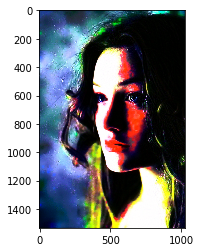

In [15]:
output = style_transfer(vgg, content, style, input_img, iters=1500, style_w=50000000, content_w=10)
output.save("UpdatedSets/"+set_folder+"/output_large4.png")